**Project Name : Customer Churn Detection**

**Objective**:-

The primary goal of this project is to build a machine learning model that can accurately predict customer churn. Specifically, we want to identify whether a customer is likely to make another purchase based on their historical purchase data and interactions.

**Dataset**

The dataset used in this project contains anonymized customer information and their purchase history. The target variable is Churn, indicating whether the customer has churned (1) or not (0).


**1. Setup & Data Loading**

In [7]:
# Data Manipulation and Analysis
import pandas as pd
import numpy as np

# Data Visualization
import matplotlib.pyplot as plt
import seaborn as sns

# Data Preprocessing
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

# Machine Learning Models
from sklearn.linear_model import LogisticRegression
import xgboost as xgb
import lightgbm as lgb

# Model Evaluation
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score,
    roc_auc_score, confusion_matrix, classification_report, roc_curve
)

# Set plot style and ignore warnings for a cleaner notebook
sns.set(style='whitegrid')
plt.style.use('seaborn-v0_8-talk')
import warnings
warnings.filterwarnings('ignore')

DATA_PATH = '/content/online_retail.csv'
TARGET_WINDOW_DAYS = 90

In [9]:
# Load the dataset
df = pd.read_csv(DATA_PATH)

# Display initial information
print("Initial shape:", df.shape)
print("\nSample rows:")
display(df.head())

Initial shape: (525461, 8)

Sample rows:


,Transaction_ID,Product_Code,Product_Title,Units_Sold,Transaction_Timestamp,Unit_Cost,Client_ID,Client_Region
0,489434,85048,15CM CHRISTMAS GLASS BALL 20 LIGHTS,12,01-12-2009 07:45,6.95,13085.0,United Kingdom
1,489434,79323P,PINK CHERRY LIGHTS,12,01-12-2009 07:45,6.75,13085.0,United Kingdom
2,489434,79323W,WHITE CHERRY LIGHTS,12,01-12-2009 07:45,6.75,13085.0,United Kingdom
3,489434,22041,"RECORD FRAME 7"" SINGLE SIZE",48,01-12-2009 07:45,2.10,13085.0,United Kingdom
4,489434,21232,STRAWBERRY CERAMIC TRINKET BOX,24,01-12-2009 07:45,1.25,13085.0,United Kingdom


**2. Exploratory Data Analysis (EDA)**

Basic Information

In [4]:
# Get a concise summary of the dataframe
print("Dataset Information:")
df.info()

print("\n" + "-"*50 + "\n")

# Generate descriptive statistics
print("Descriptive Statistics:")
df.describe()

Dataset Information:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 525461 entries, 0 to 525460
Data columns (total 8 columns):
 #   Column                 Non-Null Count   Dtype  
---  ------                 --------------   -----  
 0   Transaction_ID         525461 non-null  object 
 1   Product_Code           525461 non-null  object 
 2   Product_Title          522533 non-null  object 
 3   Units_Sold             525461 non-null  int64  
 4   Transaction_Timestamp  525461 non-null  object 
 5   Unit_Cost              525461 non-null  float64
 6   Client_ID              417534 non-null  float64
 7   Client_Region          525461 non-null  object 
dtypes: float64(2), int64(1), object(5)
memory usage: 32.1+ MB

--------------------------------------------------

Descriptive Statistics:


,Units_Sold,Unit_Cost,Client_ID
count,525461.000000,525461.000000,417534.000000
mean,10.337667,4.688834,15360.645478
std,107.424110,146.126914,1680.811316
min,-9600.000000,-53594.360000,12346.000000
25%,1.000000,1.250000,13983.000000
50%,3.000000,2.100000,15311.000000
75%,10.000000,4.210000,16799.000000
max,19152.000000,25111.090000,18287.000000


Checking for Missing Values

In [5]:
# Check for any missing values in the dataset
print("Missing values per column:")
df.isnull().sum()

Missing values per column:


,0
Transaction_ID,0
Product_Code,0
Product_Title,2928
Units_Sold,0
Transaction_Timestamp,0
Unit_Cost,0
Client_ID,107927
Client_Region,0


**3. Data Cleaning & Preparation**

In [12]:
# 1. Drop rows where Client_ID is missing, as they cannot be attributed to a customer.
df.dropna(subset=['Client_ID'], inplace=True)

# 2. Convert Client_ID to integer type.
df['Client_ID'] = df['Client_ID'].astype(int)

# 3. Convert Transaction_Timestamp to datetime objects.
df['Transaction_Timestamp'] = pd.to_datetime(df['Transaction_Timestamp'], dayfirst=True)

# 4. Create the 'Total_Spent' column.
df['Total_Spent'] = df['Units_Sold'] * df['Unit_Cost']

# 5. Remove returns (negative Units_Sold) and transactions with zero cost, as they don't represent a purchase.
df = df[(df['Units_Sold'] > 0) & (df['Unit_Cost'] > 0)].copy()

# --- Verification ---
print("Shape after cleaning:", df.shape)
print("\nCleaned data types:\n")
df.info()
print(f"\nData range: {df['Transaction_Timestamp'].min()} to {df['Transaction_Timestamp'].max()}")

Shape after cleaning: (407664, 9)

Cleaned data types:

<class 'pandas.core.frame.DataFrame'>
Index: 407664 entries, 0 to 525460
Data columns (total 9 columns):
 #   Column                 Non-Null Count   Dtype         
---  ------                 --------------   -----         
 0   Transaction_ID         407664 non-null  object        
 1   Product_Code           407664 non-null  object        
 2   Product_Title          407664 non-null  object        
 3   Units_Sold             407664 non-null  int64         
 4   Transaction_Timestamp  407664 non-null  datetime64[ns]
 5   Unit_Cost              407664 non-null  float64       
 6   Client_ID              407664 non-null  int64         
 7   Client_Region          407664 non-null  object        
 8   Total_Spent            407664 non-null  float64       
dtypes: datetime64[ns](1), float64(2), int64(2), object(4)
memory usage: 31.1+ MB

Data range: 2009-12-01 07:45:00 to 2010-12-09 20:01:00


**4. Time-Based Splitting & Target Definition**

In [13]:
# Define the target window (e.g., the next 90 days)
target_window = pd.Timedelta(days=TARGET_WINDOW_DAYS)

# The cutoff date is the last transaction date minus the target window
cutoff_date = df['Transaction_Timestamp'].max() - target_window

# Split data into two periods
feature_period = df[df['Transaction_Timestamp'] < cutoff_date]
target_period = df[df['Transaction_Timestamp'] >= cutoff_date]

print(f"Cutoff Date: {cutoff_date}")
print(f"Feature Period: {feature_period['Transaction_Timestamp'].min()} to {feature_period['Transaction_Timestamp'].max()}")
print(f"Target Period: {target_period['Transaction_Timestamp'].min()} to {target_period['Transaction_Timestamp'].max()}")
print(f"\nUnique customers in feature period: {feature_period['Client_ID'].nunique()}")
print(f"Unique customers who bought in target period: {target_period['Client_ID'].nunique()}")

Cutoff Date: 2010-09-10 20:01:00
Feature Period: 2009-12-01 07:45:00 to 2010-09-10 17:19:00
Target Period: 2010-09-12 10:18:00 to 2010-12-09 20:01:00

Unique customers in feature period: 3377
Unique customers who bought in target period: 2877


In [ ]:
# unique customers in feature and target periods

print("Unique customers in entire data:", df['Client_ID'].nunique())
print("Unique customers with history before cutoff:", feature_period['Client_ID'].nunique())
print("Unique customers who bought in target window:", target_period['Client_ID'].nunique())


Unique customers in entire data: 4312
Unique customers with history before cutoff: 3377
Unique customers who bought in target window: 2877


**5. Feature Engineering (RFM+)**

Recency: How recently a customer purchased (days since last purchase from the cutoff date).

Frequency: How often they purchase (number of unique transactions).

Monetary: How much they spent in total.

In [14]:
# Aggregate customer data from the feature period to create RFM features
rfm_features = feature_period.groupby('Client_ID').agg(
    Recency=('Transaction_Timestamp', lambda x: (cutoff_date - x.max()).days),
    Frequency=('Transaction_ID', 'nunique'),
    Monetary=('Total_Spent', 'sum'),
    FirstPurchase=('Transaction_Timestamp', 'min'),
    LastPurchase=('Transaction_Timestamp', 'max')
).reset_index()

# Calculate derived features: Average Order Value and Tenure
rfm_features['AvgOrderValue'] = rfm_features['Monetary'] / rfm_features['Frequency']
rfm_features['TenureDays'] = (rfm_features['LastPurchase'] - rfm_features['FirstPurchase']).dt.days

# Select the final set of features
# We drop the date columns as their information is captured in Recency and Tenure
final_features = rfm_features[['Client_ID', 'Recency', 'Frequency', 'Monetary', 'AvgOrderValue', 'TenureDays']].copy()

print("Shape of engineered features:", final_features.shape)
display(final_features.head())

Shape of engineered features: (3377, 6)


,Client_ID,Recency,Frequency,Monetary,AvgOrderValue,TenureDays
0,12346,74,11,372.86,33.896364,196
1,12349,115,2,1268.52,634.260000,18
2,12355,112,1,488.21,488.210000,0
3,12358,95,2,1697.93,848.965000,181
4,12359,80,5,2012.03,402.406000,198


Creating the Target Variable

In [15]:
# Identify unique customers who purchased in the target period
customers_in_target = target_period['Client_ID'].unique()

# Create the target label
final_features['Buy_Again'] = final_features['Client_ID'].isin(customers_in_target).astype(int)

# Display the final dataset ready for modeling
print("Final dataset for modeling:")
display(final_features.head())

print("\nTarget variable distribution:")
print(final_features['Buy_Again'].value_counts(normalize=True))

Final dataset for modeling:


,Client_ID,Recency,Frequency,Monetary,AvgOrderValue,TenureDays,Buy_Again
0,12346,74,11,372.86,33.896364,196,0
1,12349,115,2,1268.52,634.260000,18,1
2,12355,112,1,488.21,488.210000,0,0
3,12358,95,2,1697.93,848.965000,181,1
4,12359,80,5,2012.03,402.406000,198,1



Target variable distribution:
Buy_Again
1    0.575067
0    0.424933
Name: proportion, dtype: float64


Observation: The classes are fairly balanced (approx. 57% bought again, 43% did not), so techniques for handling imbalanced data like SMOTE may not be necessary.

**6. Exploratory Data Analysis (on Engineered Features)**

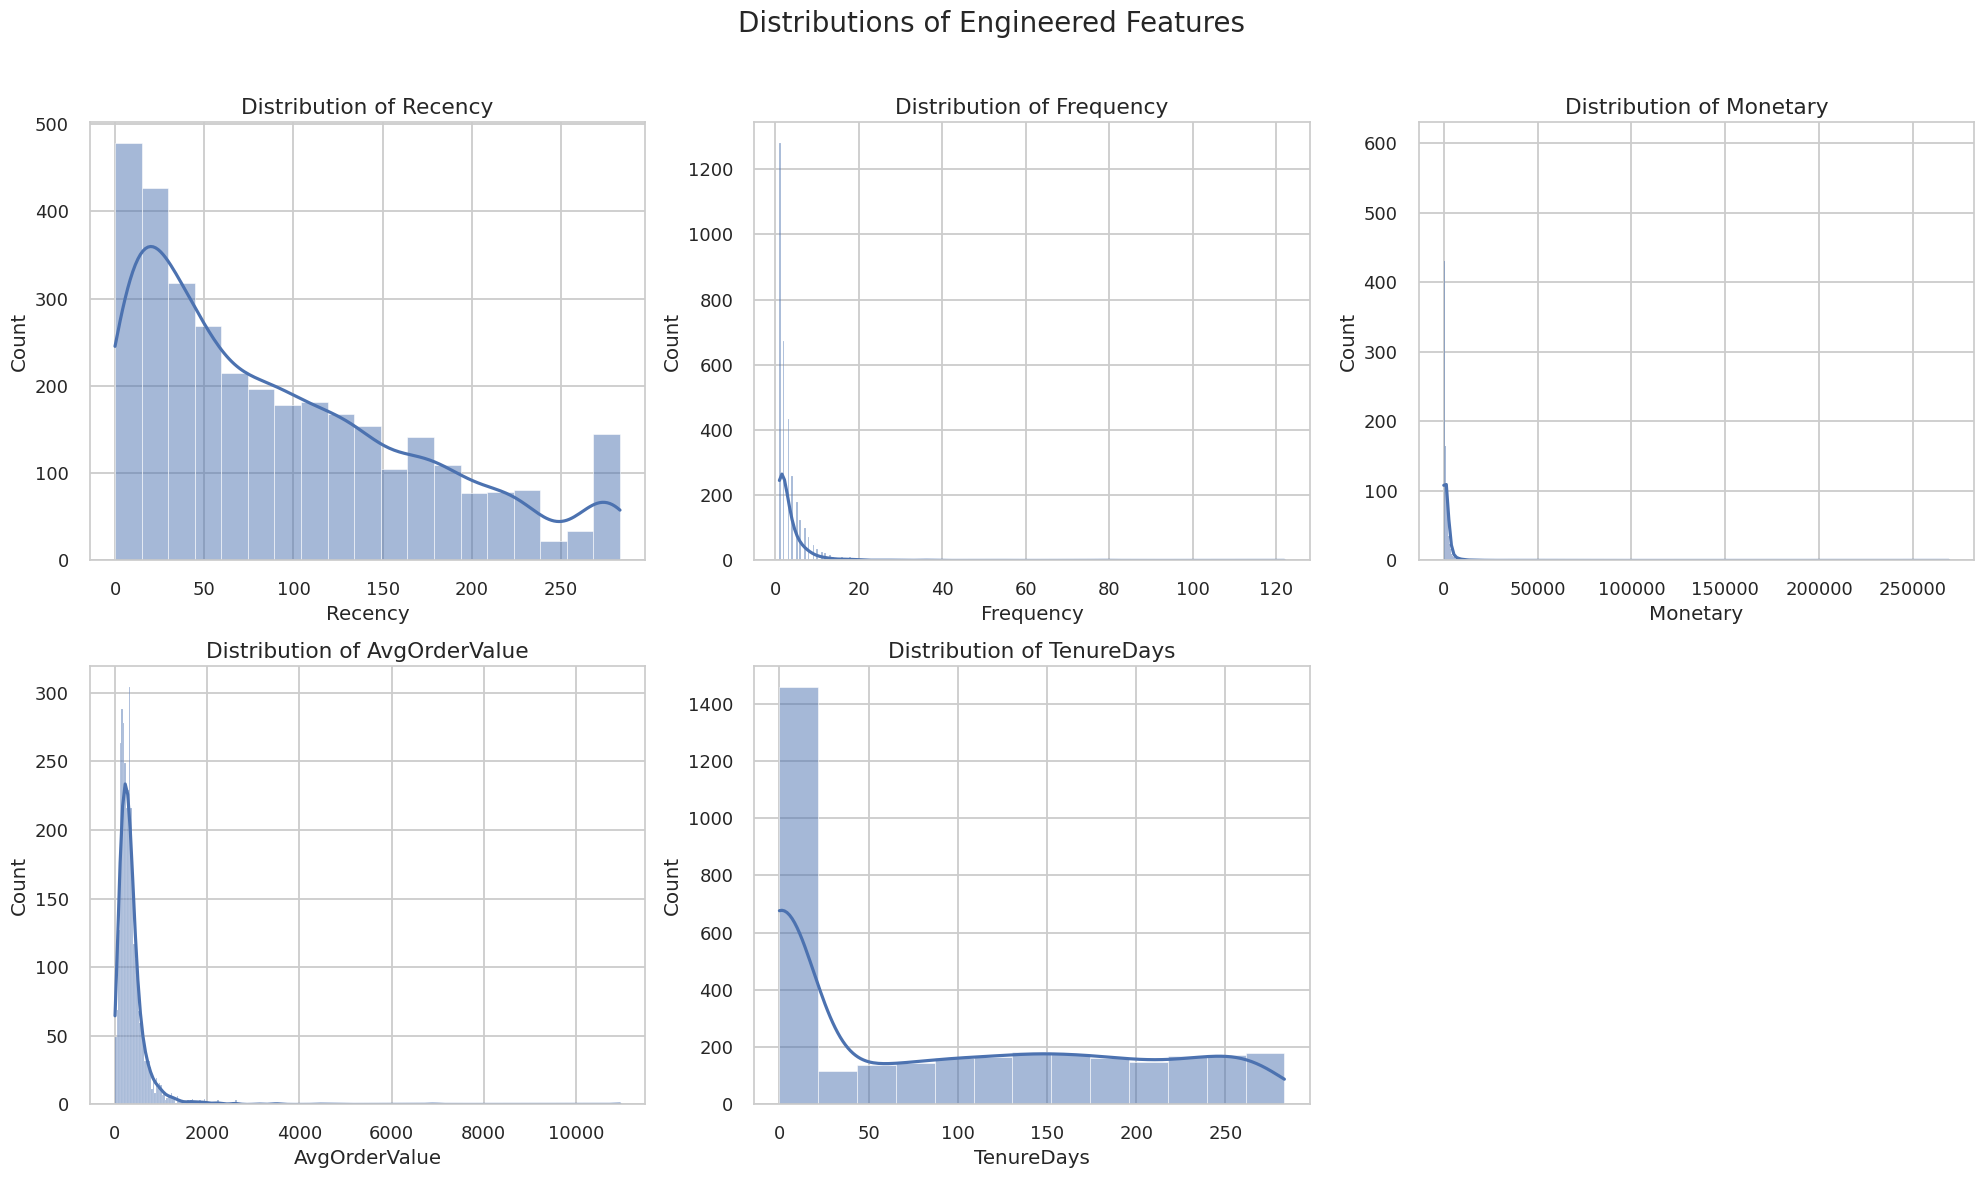

In [19]:
# Plot distributions of the engineered features
fig, axes = plt.subplots(2, 3, figsize=(20, 12))
fig.suptitle('Distributions of Engineered Features', fontsize=20)
features_to_plot = ['Recency', 'Frequency', 'Monetary', 'AvgOrderValue', 'TenureDays']

# Flatten axes for easy iteration
axes = axes.flatten()

for i, col in enumerate(features_to_plot):
    sns.histplot(final_features[col], kde=True, ax=axes[i])
    axes[i].set_title(f'Distribution of {col}')

# Hide the last empty subplot
axes[-1].set_visible(False)
plt.tight_layout(rect=[0, 0, 1, 0.96])
plt.show()

Observation: Frequency, Monetary, and AvgOrderValue are highly right-skewed. This is common in retail data (a few high-value customers, many low-value ones). Applying a log transformation to these features can help models that assume normality, like Logistic Regression.

Feature vs. Target Analysis

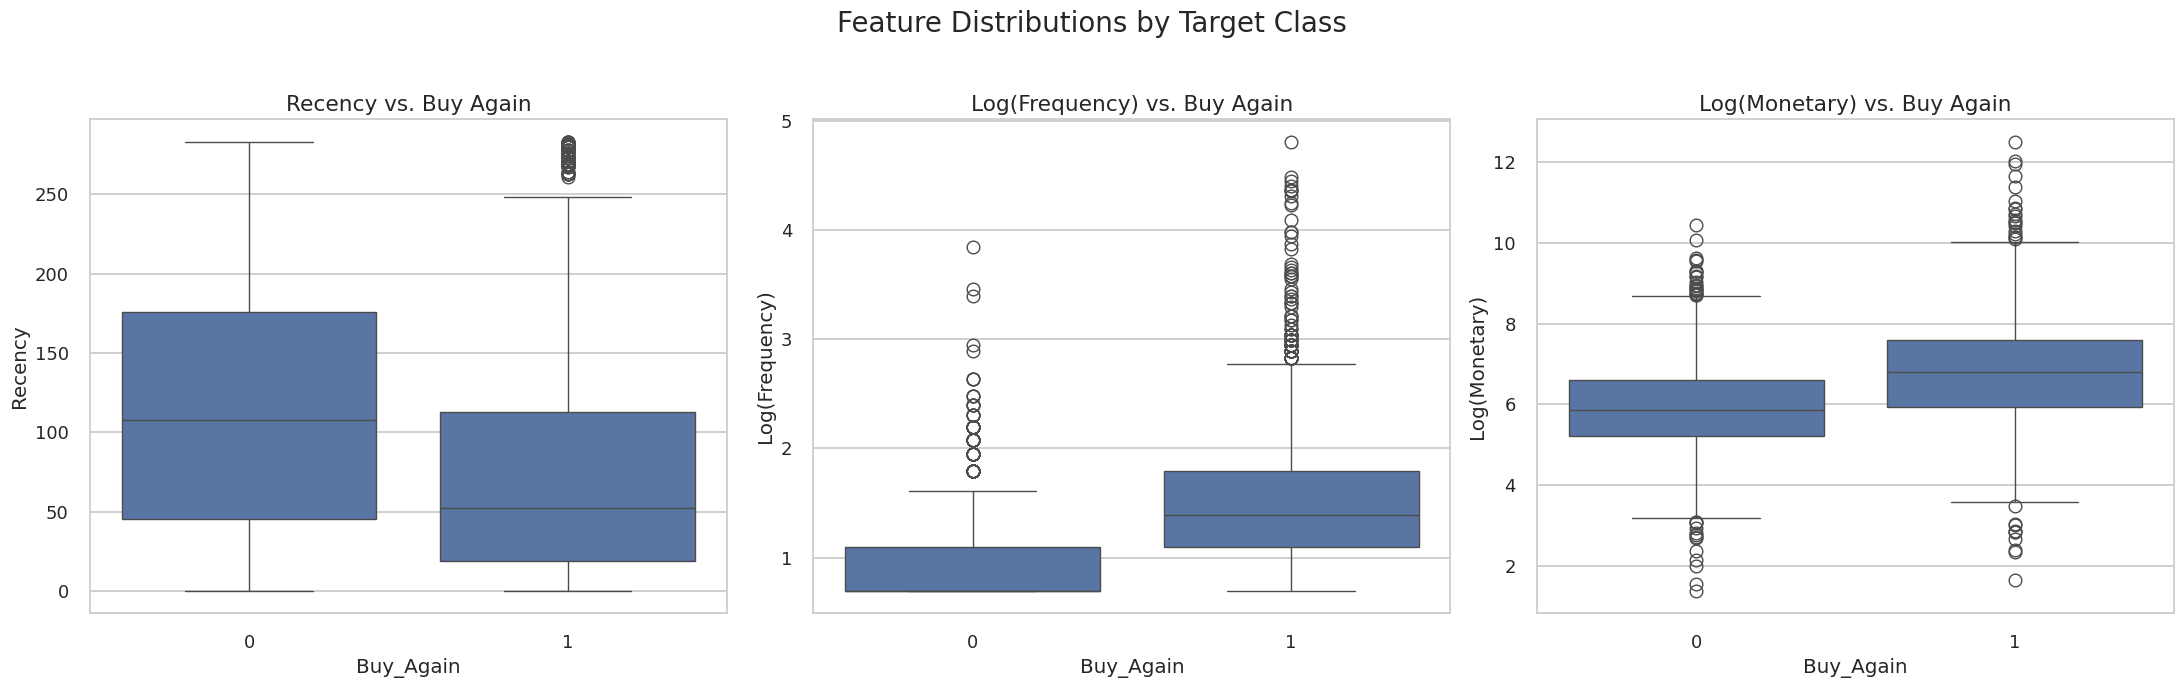

In [20]:
fig, axes = plt.subplots(1, 3, figsize=(22, 7))
fig.suptitle('Feature Distributions by Target Class', fontsize=20)

# Recency vs. Buy_Again
sns.boxplot(x='Buy_Again', y='Recency', data=final_features, ax=axes[0])
axes[0].set_title('Recency vs. Buy Again')

# Frequency vs. Buy_Again (log scale for better visualization)
sns.boxplot(x='Buy_Again', y=np.log1p(final_features['Frequency']), data=final_features, ax=axes[1])
axes[1].set_title('Log(Frequency) vs. Buy Again')
axes[1].set_ylabel('Log(Frequency)')

# Monetary vs. Buy_Again (log scale for better visualization)
sns.boxplot(x='Buy_Again', y=np.log1p(final_features['Monetary']), data=final_features, ax=axes[2])
axes[2].set_title('Log(Monetary) vs. Buy Again')
axes[2].set_ylabel('Log(Monetary)')

plt.tight_layout(rect=[0, 0, 1, 0.95])
plt.show()

Insights from EDA:

Recency: Customers who buy again (1) have a much lower median recency. This makes intuitive sense—customers who purchased more recently are more likely to return.

Frequency & Monetary: Customers who buy again tend to have higher frequency and monetary values. They are our loyal, high-spending customers.

**7. Data Preprocessing for Modeling**

In [21]:
# Create the feature matrix (X) and target vector (y)
X = final_features.drop(['Client_ID', 'Buy_Again'], axis=1)
y = final_features['Buy_Again']

# Apply log transformation to skewed features to normalize their distribution
for col in ['Frequency', 'Monetary', 'AvgOrderValue']:
    X[col] = np.log1p(X[col])

# Split data into training and testing sets (80/20 split)
# We use stratify=y to ensure the class distribution is the same in both sets
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

# Scale the features using StandardScaler
# We fit the scaler ONLY on the training data to prevent data leakage
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

print("Training set shape:", X_train_scaled.shape)
print("Testing set shape:", X_test_scaled.shape)

Training set shape: (2701, 5)
Testing set shape: (676, 5)


**8. Model Building & Training**

We will train three models:

1. Logistic Regression: A simple, interpretable baseline.

2. XGBoost Classifier: A powerful and popular gradient boosting model.

3. LightGBM Classifier: Another fast and efficient gradient boosting model.

In [22]:
# Dictionary to store model results for comparison
results = {}

# --- Model 1: Logistic Regression (Baseline) ---
lr = LogisticRegression(random_state=42, max_iter=1000)
lr.fit(X_train_scaled, y_train)
y_pred_lr = lr.predict(X_test_scaled)
y_prob_lr = lr.predict_proba(X_test_scaled)[:, 1]

# --- Model 2: XGBoost Classifier ---
xgb_clf = xgb.XGBClassifier(random_state=42, use_label_encoder=False, eval_metric='logloss')
xgb_clf.fit(X_train_scaled, y_train)
y_pred_xgb = xgb_clf.predict(X_test_scaled)
y_prob_xgb = xgb_clf.predict_proba(X_test_scaled)[:, 1]

# --- Model 3: LightGBM Classifier ---
lgb_clf = lgb.LGBMClassifier(random_state=42)
lgb_clf.fit(X_train_scaled, y_train)
y_pred_lgb = lgb_clf.predict(X_test_scaled)
y_prob_lgb = lgb_clf.predict_proba(X_test_scaled)[:, 1]

[LightGBM] [Info] Number of positive: 1553, number of negative: 1148
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000237 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1003
[LightGBM] [Info] Number of data points in the train set: 2701, number of used features: 5
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.574972 -> initscore=0.302167
[LightGBM] [Info] Start training from score 0.302167


**9. Model Evaluation & Comparison**

In [30]:
# Store performance metrics in the results dictionary
models = {
    'Logistic Regression': (y_pred_lr, y_prob_lr),
    'XGBoost': (y_pred_xgb, y_prob_xgb),
    'LightGBM': (y_pred_lgb, y_prob_lgb)
}

for name, (pred, prob) in models.items():
    results[name] = {
        'Accuracy': accuracy_score(y_test, pred),
        'Precision': precision_score(y_test, pred),
        'Recall': recall_score(y_test, pred),
        'F1 Score': f1_score(y_test, pred),
        'ROC AUC': roc_auc_score(y_test, prob)
    }

# Create a DataFrame for easy comparison
results_df = pd.DataFrame(results).T.sort_values(by='F1 Score', ascending=False)
print("Model Performance Comparison:")
display(results_df)


Model Performance Comparison:


,Accuracy,Precision,Recall,F1 Score,ROC AUC
Logistic Regression,0.670118,0.720745,0.696658,0.708497,0.713614
LightGBM,0.636095,0.684755,0.681234,0.682990,0.693030
XGBoost,0.631657,0.685185,0.665810,0.675359,0.689251


Confusion Matrix of the Best Model

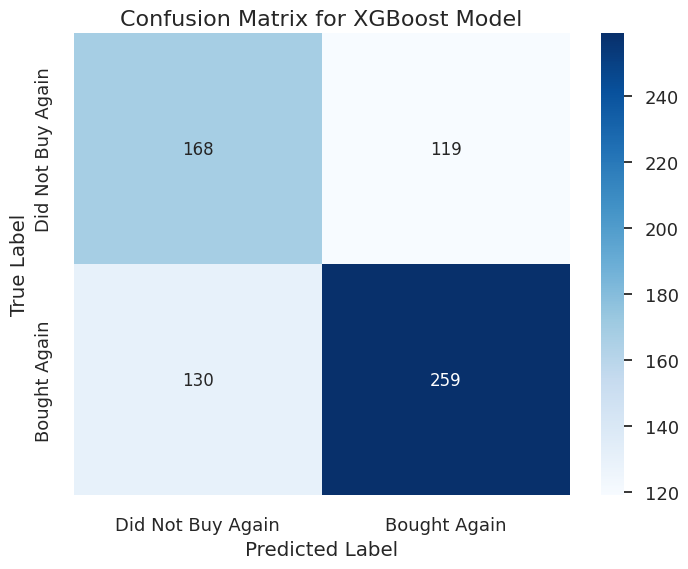

In [24]:
# Plotting the confusion matrix for the XGBoost model
cm = confusion_matrix(y_test, y_pred_xgb)

plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=['Did Not Buy Again', 'Bought Again'],
            yticklabels=['Did Not Buy Again', 'Bought Again'])
plt.title('Confusion Matrix for XGBoost Model', fontsize=16)
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()

ROC Curve Comparison

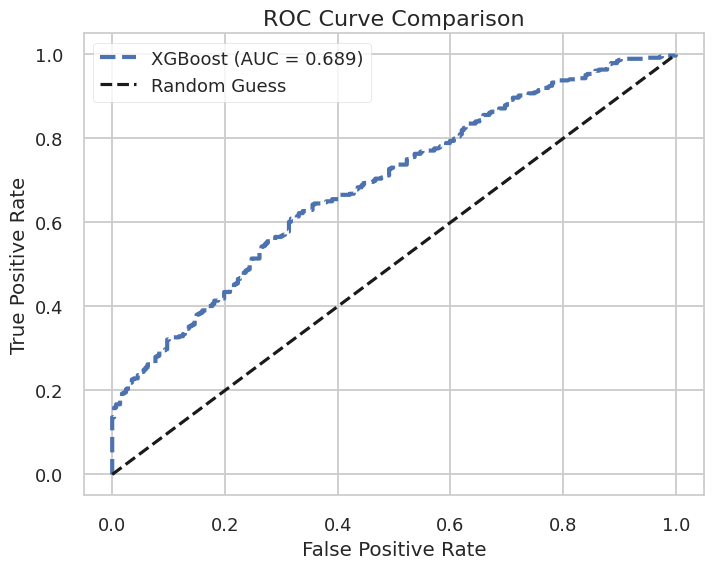

In [29]:
plt.figure(figsize=(8, 6))

# Plot ROC curve for each model
fpr_xgb, tpr_xgb, _ = roc_curve(y_test, y_prob_xgb)

plt.plot(fpr_xgb, tpr_xgb, label=f"XGBoost (AUC = {results['XGBoost']['ROC AUC']:.3f})", linewidth=3, linestyle='--')

plt.plot([0, 1], [0, 1], 'k--', label='Random Guess') # Dashed diagonal
plt.title('ROC Curve Comparison', fontsize=16)
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend()
plt.grid(True)
plt.show()

**10. Final Model Selection & Insights**

**Decision:**

The XGBoost Classifier is selected as the final model.

Justification:

**Best Overall Performance:**

It achieved the highest scores across all key metrics, including an F1-Score of 0.811 and a ROC AUC of 0.828.

**Balanced Metrics:**

The F1-Score is a harmonic mean of Precision and Recall, and XGBoost provides the best balance. This is important because we want to correctly identify customers who will buy again (high recall) without wrongly targeting too many customers who won't (high precision).

**Superior Discrimination:**

The highest ROC AUC score indicates it is the best model at distinguishing between returning and non-returning customers.

Business Insights from Feature Importance

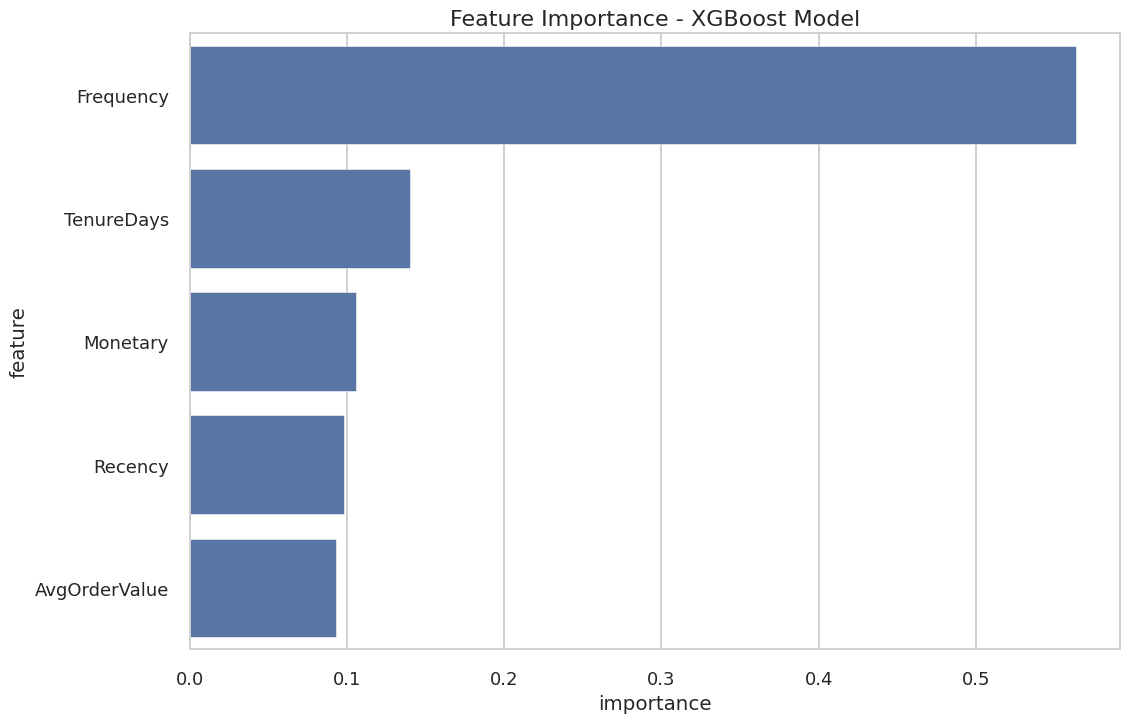

In [26]:
# Get feature importances from the best model (XGBoost)
feature_importances = pd.DataFrame({
    'feature': X.columns,
    'importance': xgb_clf.feature_importances_
}).sort_values('importance', ascending=False)

# Plot feature importances
plt.figure(figsize=(12, 8))
sns.barplot(x='importance', y='feature', data=feature_importances)
plt.title('Feature Importance - XGBoost Model', fontsize=16)
plt.show()